In [1225]:
import pandas as pd
import util
import pyBigWig
import seaborn as sns
import numpy as np
from matplotlib import pyplot

In [30]:
ind=pd.read_csv('data/ind.csv',index_col=0,engine='c',usecols=['_'])

In [4]:
files=['SRR3264'+str(i) +'.meth' for i in [413,414,415,416,722]]
n=8
dfs=[]
for f in files:
    print(f,end=',')
    df=pd.read_csv('data/meth/fib/'+f,sep='\t',header=None,nrows=5*10**n)
    df=df[df[5]>0]
    df.index=df[0].str[3:5]+'_'+df[1].astype(str)
    #df=df[df.index.isin(ind.index)][[4]]
    df=df[[4]]
    print(round(len(df)/10**6))
    df.columns=[f]
    dfs.append(df)    

SRR3264413.meth,27
SRR3264414.meth,27
SRR3264415.meth,27
SRR3264416.meth,27
SRR3264722.meth,27


In [ ]:
df=dfs[0]
for i in range(1,len(files)):
    print(i,end=',')
    dt=dfs[i]
    df=df.merge(dt,left_index=True,right_index=True)
print(df.shape)    

1,

In [ ]:
df.to_csv('data/meth/fib_all.csv')

In [7]:
df.shape

(25606034, 5)

In [44]:
tss=pd.read_csv('data/tss.csv',index_col=0)
t4=[
    'Human_CD4T-Newborn.meth.bw',
    'Human_CD4T-100yr.meth.bw',
]
for t4_bw in t4:
    name=t4_bw.split('.')[0]
    cd4=util.bw2df('data/source/t4/'+t4_bw,v)##tss
    cd4=cd4[['beta']]
    cd4.columns=[name]
    cd4.to_csv('data/meth/t4'+name+'.csv')
dfs=[]
fs=['Human_CD4T-Newborn',
    'Human_CD4T-100yr'
   ]
for f in fs:
    df=pd.read_csv('data/meth/t4'+f+'.csv',index_col=0)
    df.columns=[f]    
    dfs.append(df)
df=dfs[0]
for dt in dfs[1:]:
    df=df.merge(dt,left_index=True,right_index=True)        
df.round(3).to_csv('data/meth/t4_v.csv')

(184421, 1)
(184421, 1)


In [111]:
v=pd.read_table('data/v/pcan38.bed',header=None)[[0,1,2,3]]
v=v[~(v[0].isin(['chrX','chrY']))&~(v[0].str.contains('rand'))]
len(v)

1212

In [112]:
v=v[v[3]=='pCanyon'][[0,1,2]]
len(v)

344

In [113]:
v['d']=v[2]-v[1]

In [93]:
v.columns=['chrom','chromStart','chromEnd']

In [94]:
v['chrom']=v.chrom.str[3:].astype(int)

In [96]:
df.shape

(138913, 2)

In [45]:
df.mean()

Human_CD4T-Newborn    0.075273
Human_CD4T-100yr      0.153494
dtype: float64

In [98]:
dg=df[df.index.isin(ind.index)]
print(dg.shape)
dg.mean()

(108754, 2)


Human_CD4T-Newborn    0.034783
Human_CD4T-100yr      0.098558
dtype: float64

In [4]:
h=pd.read_csv('data/v/hmr',sep='\t')
len(h)

43789

In [1170]:
hs=[]
for i in range(1,23):
    ch='chr'+str(i)
    h1='http://smithdata.usc.edu/methbase/data/Xie-Human-2013/Human_H1/tracks_hg38/Human_H1.hmr.bb'
    h1=pyBigWig.open(h1)
    h1=h1.entries(ch,1,-1)
    h1=pd.DataFrame(h1)
    h1['ch']=ch
    h1['d']=h1[1]-h1[0]
    hs.append(h1)
len(hs)    

In [1195]:
gss=pd.DataFrame()
for ch in range(1,23):
    h1=hs[ch-1]
    rs=h1[[0,1]].values
    gs=[]
    while len(gs)<len(rs):
        gs=[]
        skip=0
        for i in range(len(rs)-1):
            if skip==1:
                skip=0
                continue
            d0=rs[i][1]-rs[i][0]
            d1=rs[i+1][1]-rs[i+1][0]
            g=rs[i+1][0]-rs[i][1]
            if d0+d1>10*g:
                gs.append([rs[i][0],rs[i+1][1]])
                skip=1
            else :
                gs.append([rs[i][0],rs[i][1]])
        gs.append(rs[-1])
        rs=gs.copy()
    print(len(gs),end=',')
    gs=pd.DataFrame(gs)
    gs['ch']='chr'+str(ch)
    gss=gss.append(gs)

3478,2344,1784,1372,1603,1956,1703,1351,1472,1467,1873,1672,704,1072,1108,1424,1953,593,2332,1039,368,840,

In [1196]:
gss['d']=gss[1]-gss[0]
gss.d.sum()/10**6

40.433648

In [1197]:
tss=pd.read_csv('data/tss.csv',index_col=0)
tss=tss.groupby('chrom')['ts'].apply(list)

In [1198]:
gsp=[]
for i,r in gss.iterrows():
    rr=set(range(r[0],r[1]))
    ch=int(r['ch'][3:])
    ts=rr.intersection(tss[ch])
    if len(ts)>0:
        rr=list(r)
        rr.append(list(ts)[0])
        gsp.append(rr)
len(gsp)        

12224

In [1199]:
gsp=pd.DataFrame(gsp)
gsp.sort_values(3).tail()

,0,1,2,3,4
1864,176080658,176115187,chr2,34529,176092720
10099,48592971,48629621,chr17,36650,48611017
4920,96987423,97028039,chr7,40616,97005552
7931,114662708,114703854,chr12,41146,114684175
9092,96320397,96368959,chr15,48562,96330699


In [1200]:
gsp.columns=['chromStart','chromEnd','ch','d','ts']

In [1201]:
t4=[
    'Human_CD4T-Newborn.meth.bw',
    'Human_CD4T-100yr.meth.bw',
]
names=['y','o']
for i in [0,1]:
    name=names[i]
    bw=pyBigWig.open('data/source/t4/'+t4[i])##tss
    gsp[name]=gsp.apply(lambda x: bw.stats(x['ch'],int(x['chromStart']),int(x['chromEnd']),'mean')[0],axis=1)

In [1202]:
gsp[['y','o']].mean()

y    0.050331
o    0.068909
dtype: float64

In [1203]:
gsp=gsp.sort_values('chromStart')

In [1204]:
bw='data/source/ENCFF109KCQ.bigWig'
bw=pyBigWig.open(bw)
bs=[]
for i,r in gsp.iterrows():
    b=bw.stats(r['ch'],int(r['chromStart']),int(r['chromEnd']),'max')
    bs.append(b[0])

In [1205]:
gsp['ez']=bs

In [1206]:
dg=gsp[gsp.ez>100].copy()
dg[['y','o']].mean()

y    0.071791
o    0.137750
dtype: float64

In [1207]:
dg['dd']=dg.o-dg.y
print(len(dg),len(dg[dg.dd<0]))

595 22


In [1208]:
dg.d.sum()/10**6

4.485393

In [1209]:
dg.head(1)

,chromStart,chromEnd,ch,d,ts,y,o,ez,dd
5662,110783,118698,chr9,7915,118417,0.043718,0.140045,373.292938,0.096327


In [1290]:
hvs=dg[['ch','chromStart','chromEnd','ez','d','y','o','dd']]

In [1341]:
tss=pd.read_csv('data/tss.csv',index_col=0)

In [1308]:
hvs['gb']=hvs.chrom.str[3:].astype(int)*10**9+hvs['chromStart']
hvs['ge']=hvs.chrom.str[3:].astype(int)*10**9+hvs['chromEnd']

/local/scratch/moqri/slrmtmp.30802994/ipykernel_2054/3820472268.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hvs['gb']=hvs.chrom.str[3:].astype(int)*10**9+hvs['chromStart']


In [1333]:
dic=tss['tss'].to_dict()
dic = {v: k for k, v in dic.items()}

In [1338]:
tt=[]
for i,r in hvs.iterrows():
    for ts in tss.tss:
        if ts>r['gb'] and ts<r['ge']:
            tt.append(dic[ts])
            break

In [1339]:
hvs.index=tt

In [1346]:
hvs=hvs.drop(['gb','ge'],axis=1)

In [1348]:
hvs.columns=['chrom','chromStart','chromEnd','EZH2_chip','valley_length','DNAm_young_blood','DNAm_old_blood','DNAm_diff']
hvs.round(3).sort_values('valley_length').to_csv('data/h1_vallyes.csv')

In [1210]:
dg['r']=dg.apply(lambda x:list(range(x['chromStart'],x['chromEnd'])),axis=1)

In [1211]:
dg['chi']=dg['ch'].str[3:].astype(int)

In [1212]:
dg['r']=dg.apply(lambda x: set(range(x['chi']*10**9+x['chromStart'],x['chi']*10**9+x['chromEnd'])),axis=1)

In [1213]:
dgr=dg.r.values
dgr=set.union(*dgr)
len(dgr)/10**6

4.485393

In [1264]:
hv=pd.DataFrame(dgr)

In [1271]:
hv.index='chr'+hv[0].astype(str).str[:-9]+'_'+hv[0].astype(str).str[-9:].astype(int).astype(str)

In [1276]:
hv.index=hv.index.rename('_')

In [1283]:
hv=hv.sort_values(0)
len(hv)/10**6

4.485393

In [1279]:
hv.to_csv('data/hv.csv')

In [1218]:
sp=['SRR10429'+ i +'.meth.sym' for i in  ['03','06','07','09','11','13']]
se=['SRR10429'+ i +'.meth.sym' for i in  ['04','05','08','10','12','14']]
sep=sp+se

In [1219]:
#sep=['SRR3264'+str(i) +'.meth' for i in [413,414,415,416,722]]
#sep=['Young-381.meth','Young-400.meth','Young-498.meth','Old-247.meth','Old-602.meth','Old-725.meth']

In [1220]:
dfs=[]
for s in sep:
    print(s,end=',')
    df=pd.read_csv('data/meth/skin/'+s,engine='c',sep='\t',header=None,nrows=10**8)
    #df=df[df[0]==ch]
    df.index=df[1]
    #df=df[df.index.isin(dgr)][4]
    df['ch']=df[0].str[3:]
    df=df[~df['ch'].isin(['M','X','Y'])]
    df['chi']=df.ch.astype(int)
    df.index=df.chi*10**9+df[1]
    df=df[df.index.isin(dgr)]
    dfs.append(df[4])

SRR1042903.meth.sym,SRR1042906.meth.sym,SRR1042907.meth.sym,SRR1042909.meth.sym,SRR1042911.meth.sym,SRR1042913.meth.sym,SRR1042904.meth.sym,SRR1042905.meth.sym,SRR1042908.meth.sym,SRR1042910.meth.sym,SRR1042912.meth.sym,SRR1042914.meth.sym,

In [1221]:
gg=pd.concat(dfs,1)
len(gg)/10**6

/local/scratch/moqri/slrmtmp.30802994/ipykernel_2054/4109693992.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  gg=pd.concat(dfs,1)


0.234805

In [1222]:
len(gg.dropna())/10**6

0.225081

<AxesSubplot:xlabel='Age', ylabel='AgeEMI'>

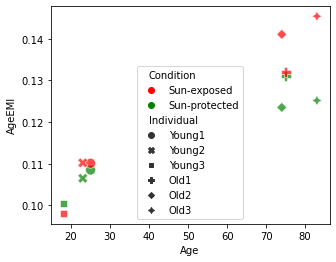

In [1234]:
p=pd.DataFrame(gg.dropna().mean())
p['age']=[25,23,18,75,74,83]+[25,23,18,75,74,83]
p['g']= ['Sun-protected']*6+['Sun-exposed']*6
p['indivudal']=2*['Young1','Young2','Young3','Old1','Old2','Old3']
p.columns=['AgeEMI','Age','Condition','Individual']
fig, ax = pyplot.subplots(figsize=(5,4))
sns.scatterplot(data=p,x='Age',y='AgeEMI',hue='Condition',hue_order=['Sun-exposed','Sun-protected'],
                palette=['red','green'],markers=True, style='Individual',s=100,alpha=.7)

In [979]:
gg['d']=gg.iloc[:,3:6].mean(1)-gg.iloc[:,:3].mean(1)

/local/scratch/moqri/slrmtmp.30802994/ipykernel_2054/111952602.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gg['d']=gg.iloc[:,3:6].mean(1)-gg.iloc[:,:3].mean(1)


/local/scratch/moqri/slrmtmp.30802994/ipykernel_2054/1269477221.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gg['d']=gg.d.rolling(1000).mean()


<AxesSubplot:xlabel='1'>

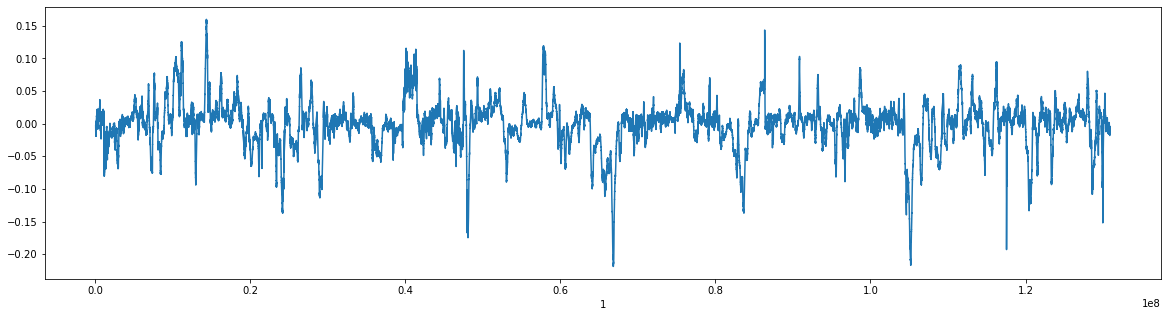

In [980]:
gg['d']=gg.d.rolling(1000).mean()
gg.d.plot(figsize=(20,5))

In [993]:
gg[gg.d>.1].head(10000)

,4,4,4,4,4,4,d
1,,,,,,,
10431457,0.842105,1.000000,0.823529,0.807692,0.738095,0.960000,0.100019
10431650,0.965517,0.833333,0.702703,0.900000,0.723404,0.962963,0.100071
10431888,0.200000,0.000000,0.300000,0.250000,0.583333,0.526316,0.100466
10431957,0.259259,0.666667,0.333333,0.566667,0.127660,0.192308,0.100432
10432011,0.107143,0.000000,0.047619,0.217391,0.403846,0.136364,0.100816
...,...,...,...,...,...,...,...
90857503,0.214286,0.000000,0.045455,0.214286,0.023810,0.409091,0.100222
90857520,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100151
90857533,0.058824,0.000000,0.040000,0.062500,0.000000,0.000000,0.100253


In [953]:
gg.d.rolling(1000).mean().sort_values().dropna()

1
66845249   -0.218807
66845223   -0.218794
66844205   -0.218646
66844043   -0.218538
66845430   -0.218412
              ...   
14367925    0.159322
14369540    0.159369
14369531    0.159596
14369156    0.159657
14369343    0.159849
Name: d, Length: 1266136, dtype: float64

In [19]:
bw='https://www.encodeproject.org/files/ENCFF109KCQ/@@download/ENCFF109KCQ.bigWig'
bw=pyBigWig.open(bw)
bs=[]
for i,r in hv.iterrows():
    b=bw.stats(r['#chrom'],r['chromStart'],r['chromEnd'],'max')
    bs.append(b[0])

In [26]:
hv['ez']=bs

/local/scratch/moqri/slrmtmp.30800439/ipykernel_25735/445542374.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hv['ez']=bs


<AxesSubplot:>

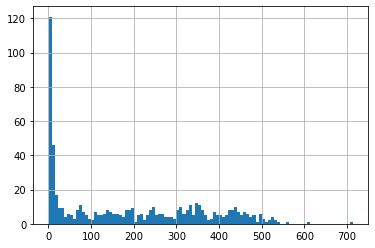

In [29]:
hv.ez.hist(bins=100)

In [37]:
v=hv[hv.ez>100][['#chrom','chromStart','chromEnd']]
v.columns=['chrom','chromStart','chromEnd']
v['chrom']=v.chrom.str[3:]

In [59]:
df['id']=df.index.str[:5]

In [81]:
dg=df.groupby('id').mean()

<AxesSubplot:>

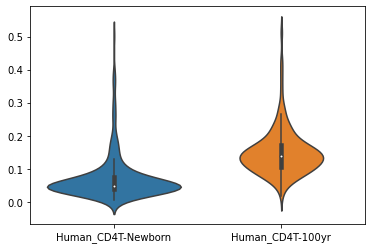

In [89]:
sn.violinplot(data=dg)

In [95]:
fib=fib[fib.index.isin(df.index)]

In [97]:
fib['id']=fib.index.str[:5]

/local/scratch/moqri/slrmtmp.30800439/ipykernel_25735/2020547035.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fib['id']=fib.index.str[:5]


In [100]:
fib=fib.groupby('id').mean()

<AxesSubplot:>

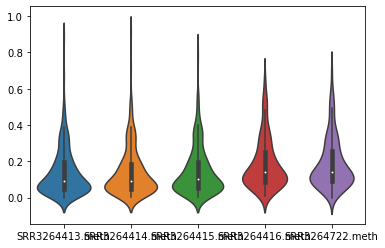

In [104]:
sn.violinplot(data=fib)

In [ ]:
fs=['Young-381','Young-400','Young-498','Old-247','Old-602','Old-725']


In [51]:
sp=['SRR10429'+ i +'.meth.sym' for i in  ['03','06','07','09','11','13']]
se=['SRR10429'+ i +'.meth.sym' for i in  ['04','05','08','10','12','14']]
sep=sp+se

In [ ]:
n=8
dfs=[]
for f in sep:
    print(f,end=',')
    df=pd.read_csv('data/wg/skin/gui/'+f,sep='\t',header=None,nrows=5*10**n)
    df=df[(df[2]=='+')&(df[3]=='CpG')&(df[5]>0)]
    df.index=df[0].str[3:5]+'_'+df[1].astype(str)
    df=df[df.index.isin(an['_'])][[4]]
    df.columns=[f]
    dfs.append(df)